## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imutils
import dlib
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from imutils.face_utils import FaceAligner, rect_to_bb

## Loading Dataset

In [2]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip

--2023-08-26 04:57:30--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.163, 52.219.158.59, 52.219.156.23, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip’

driver_drowsiness_d 100%[===================>] 121.53M  40.3MB/s    in 3.0s    

2023-08-26 04:57:34 (40.3 MB/s) - ‘driver_drowsiness_detection_modified.zip’ saved [127436131/127436131]



In [3]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle = True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)

In [4]:
print(len(X))
print(len(Y))

1452
1452


In [5]:
for i in range(len(X)):
    img = X[i]
    img =cv2.resize(img, (32, 32))
    X[i] = img

print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [6]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [7]:
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(1452, 32, 32, 3) (1452,)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state= 42)

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)


In [10]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


## Visualisation

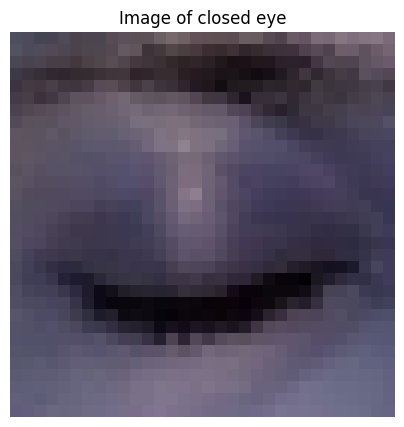

In [12]:
figure_1 = plt.figure(figsize = (5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title("Image of closed eye")
plt.axis('off')
plt.show()

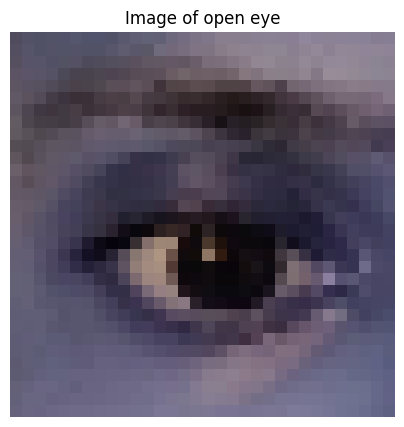

In [13]:
figure_1 = plt.figure(figsize = (5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title("Image of open eye")
plt.axis('off')
plt.show()

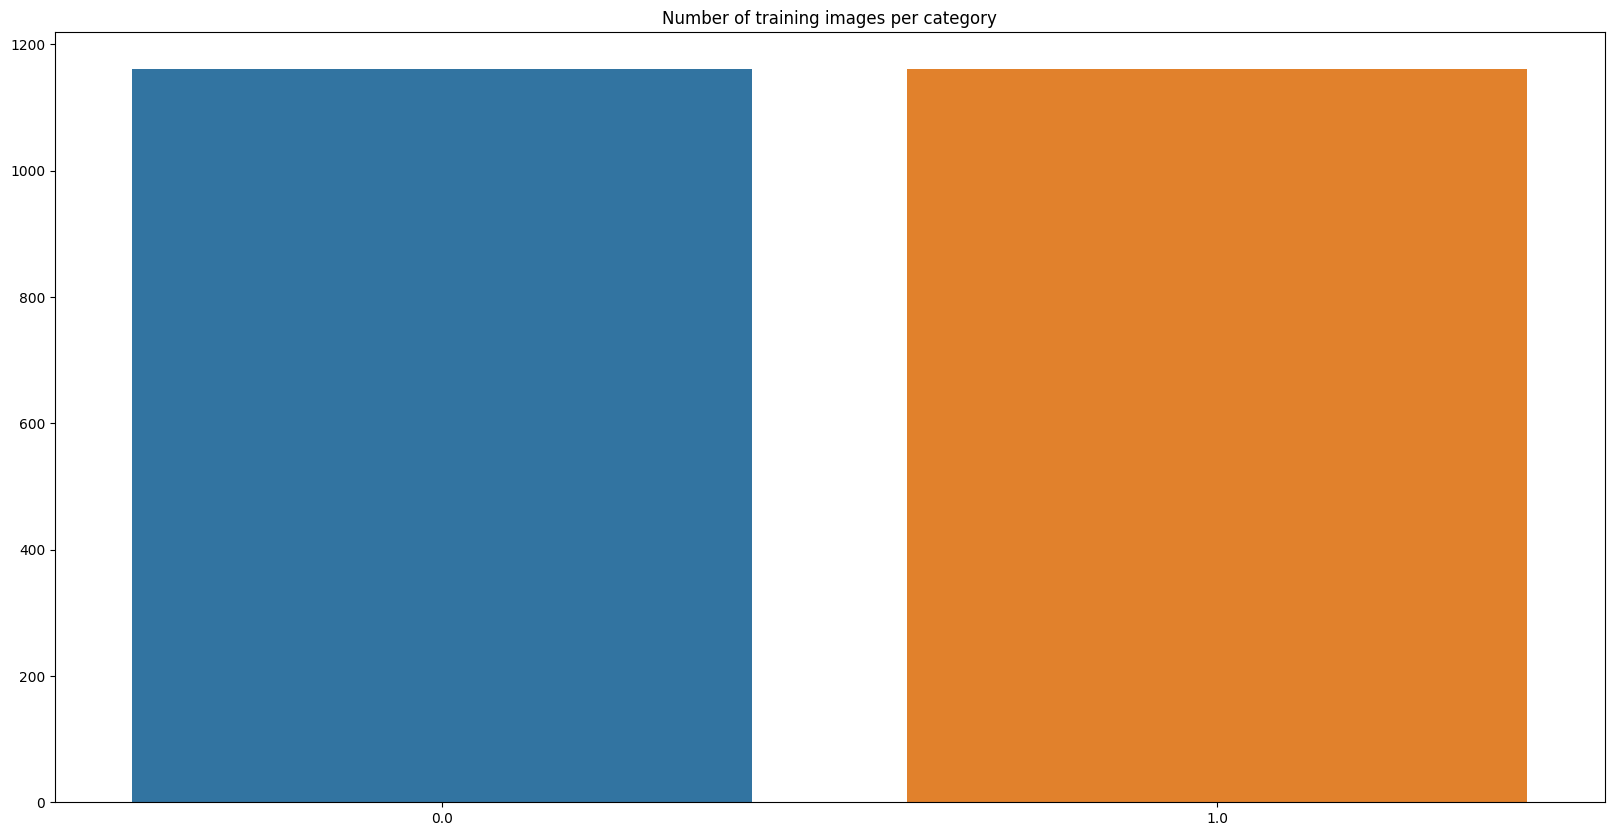

In [14]:
unique_train, count = np.unique(Y_train, return_counts= True)
plt.figure(figsize = (20, 10))
sns.barplot(x = unique_train, y = count).set_title('Number of training images per category')
plt.show()

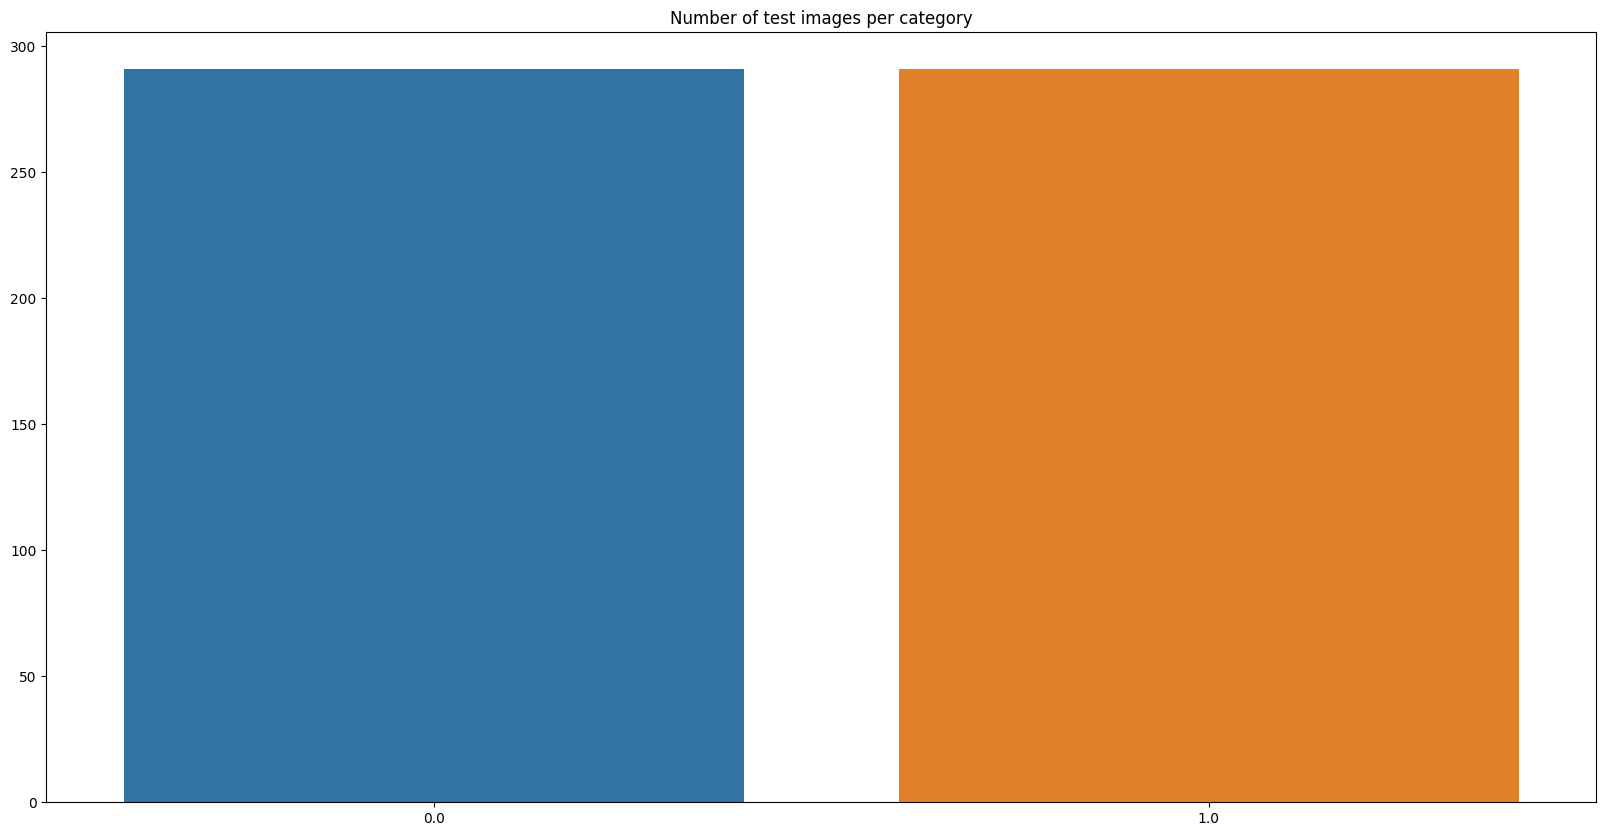

In [15]:
unique_test, count = np.unique(Y_test, return_counts= True)
plt.figure(figsize = (20, 10))
sns.barplot(x = unique_test, y = count).set_title('Number of test images per category')
plt.show()

## Model Architecture

In [16]:
def driver_drowsiness_detection_model(input_shape = (32, 32, 3)):
    model = Sequential()
    model.add(Input(shape = input_shape))

    model.add(Conv2D(32, (3, 3), padding = 'same', strides = (1, 1), name = 'conv1', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same', strides = (1, 1), name = 'conv2', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides = (2, 2)))

    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), name = 'conv3', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides = (2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), name = 'conv4', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides = (2, 2)))

    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), name = 'conv5', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), name = 'conv6', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), name = 'conv7', activation = 'relu', kernel_initializer = glorot_uniform(seed = 0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides = (2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu', kernel_initializer = glorot_uniform(seed = 0), name = 'fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu', kernel_initializer = glorot_uniform(seed = 0), name = 'fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax', kernel_initializer = glorot_uniform(seed = 0), name = 'fc3'))

    optimizer = Adam(0.0001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [17]:
model = driver_drowsiness_detection_model(input_shape = (32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0

## Training Model

Learning Rate - 0.0001
Optimizer - Adam
Number of Epochs - 200
Batch Size = 128

In [18]:
aug = ImageDataGenerator(rotation_range = 20, zoom_range = 0.2, horizontal_flip = True)

In [19]:
history = model.fit(aug.flow(X_train, Y_train, batch_size = 128), batch_size = 128, epochs = 200, validation_data = (X_test, Y_test))

Epoch 1/200
10/10 [==============================] - 25s 135ms/step - loss: 1.3964 - accuracy: 0.5151 - val_loss: 0.6916 - val_accuracy: 0.4948
Epoch 2/200
10/10 [==============================] - 1s 64ms/step - loss: 1.1270 - accuracy: 0.5547 - val_loss: 0.6822 - val_accuracy: 0.5120
Epoch 3/200
10/10 [==============================] - 1s 70ms/step - loss: 1.0570 - accuracy: 0.5668 - val_loss: 0.6680 - val_accuracy: 0.5292
Epoch 4/200
10/10 [==============================] - 1s 65ms/step - loss: 0.9407 - accuracy: 0.5883 - val_loss: 0.6398 - val_accuracy: 0.5876
Epoch 5/200
10/10 [==============================] - 1s 66ms/step - loss: 0.9272 - accuracy: 0.5874 - val_loss: 0.6224 - val_accuracy: 0.6598
Epoch 6/200
10/10 [==============================] - 1s 67ms/step - loss: 0.8713 - accuracy: 0.6021 - val_loss: 0.6165 - val_accuracy: 0.7010
Epoch 7/200
10/10 [==============================] - 1s 67ms/step - loss: 0.8374 - accuracy: 0.6253 - val_loss: 0.6132 - val_accuracy: 0.7045
Epoc

## Plotting Loss Values and Accuracy against Number of Epochs for Train Set and Test Set

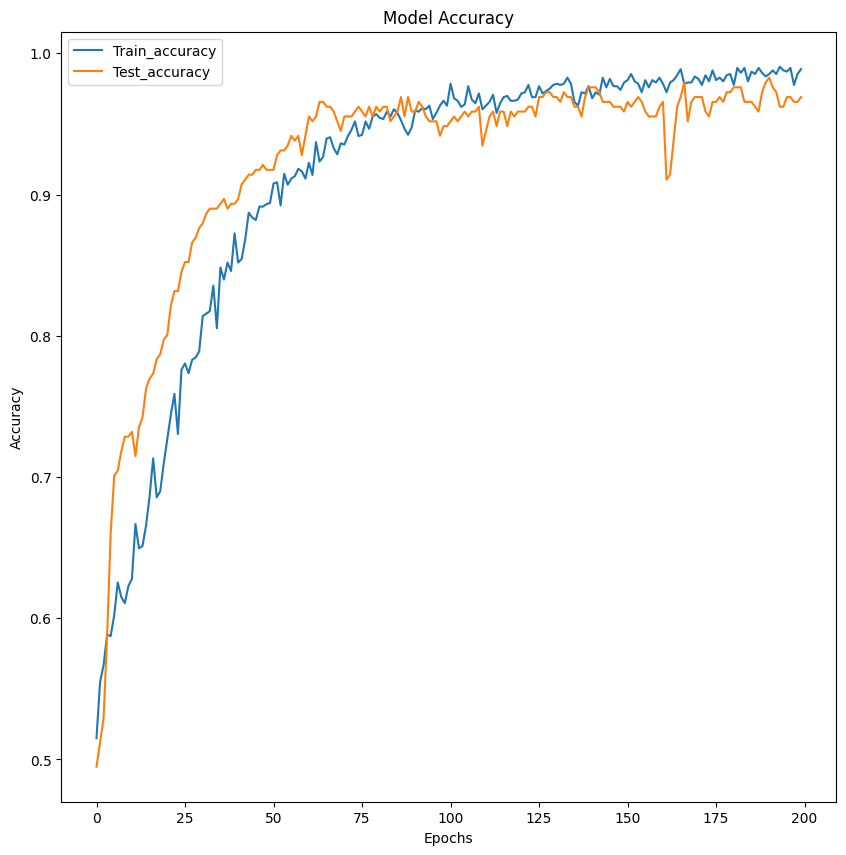

In [21]:
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

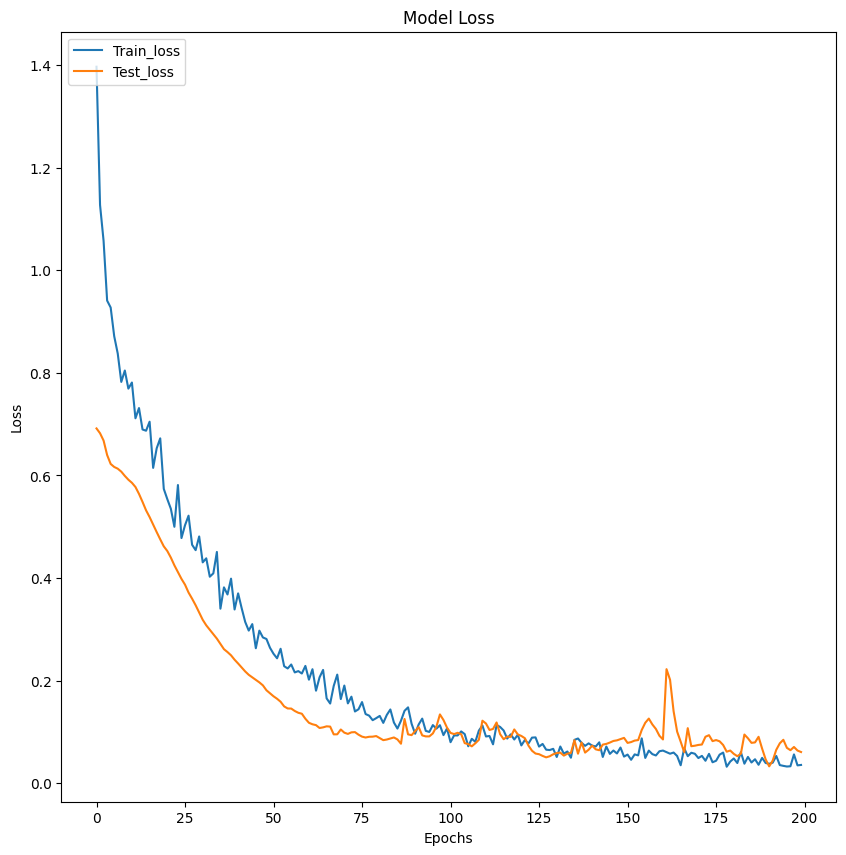

In [22]:
figure2 = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

## Evaluating Model on Test Set

In [23]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 0s 18ms/step - loss: 0.0611 - accuracy: 0.9691
Test Set Accuracy: 0.969072163105011
Test Set Loss: 0.0610516257584095


## Classification Report

In [24]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

10/10 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       148
           1       0.95      0.99      0.97       143

    accuracy                           0.97       291
   macro avg       0.97      0.97      0.97       291
weighted avg       0.97      0.97      0.97       291



## Confusion Matrix

<Axes: >

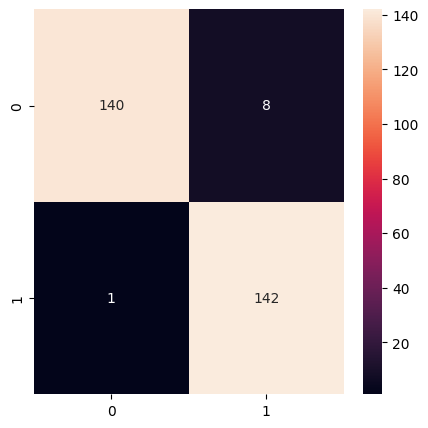

In [25]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

## Saving the Model

In [26]:
model.save('Driver_Drowsiness_Detection.h5')

## Testing Model on Images

Testing the classification performnace on random images of Open and Closed Eyes

In [27]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [28]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

1/1 [==============================] - 0s 19ms/step


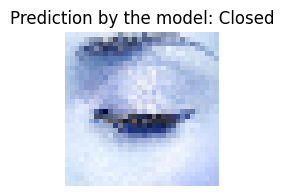

In [29]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

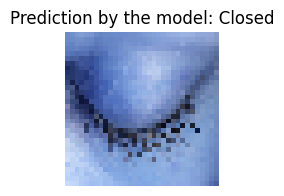

In [30]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

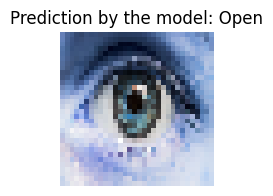

In [31]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

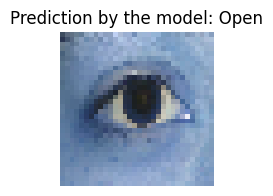

In [32]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()